In [1]:
import os
import pandas as pd
import numpy as np
import FunctionsAndData as fd

directory = '/Users/ilanastern/Desktop/aiConfidential/data'

pickle = fd.pickle

## New Influnce Score

In [2]:
def influence_matrix_updated(directory):
    all_contributions = {}  # Dictionary to store contributions
    file_metadata = []  # List of file path and type
    train_file_data = {}  # Dictionary to store training file contents 
    
    for root, _, files in os.walk(directory): # Collect file paths for processing
        for file_name in files:
            if file_name.endswith(".csv") and file_name.startswith("eval_loss_meta"):
                split_type = "train" if root.endswith("_TR.eval") else "validation" if root.endswith("_VL.eval") else None #loading files in and assigning as TR or VL
                if split_type:
                    file_metadata.append((os.path.join(root, file_name), split_type)) #adding to storage

    # Load validation files first. This only looks at the validation files not the training files yet
    for file_path, split_type in file_metadata:
        if split_type != "validation":
            continue  # Skip training files here

        try:
            data = pd.read_csv(file_path, usecols=['idx', 'f1']) # Load only necessary columns of idx and f1
        except Exception as e:
            print(f"Error reading {file_path}: {e}")
            continue

        #avg_f1 = data['f1'].mean() #average f1 score for the file across all idx valued 
        #contributions = data.assign(contribution=data['f1'] - avg_f1).groupby('idx')['contribution'].apply(list) #finds the difference between the f1 score for each point and the average of that file
        contributions = data.assign(contribution=data['f1']).groupby('idx')['contribution'].apply(list)
        
        for idx, contrib_list in contributions.items(): #storing the contribution of each data point to the dictionary
            all_contributions.setdefault(idx, []).extend(contrib_list)

    unique_datapoints = list(all_contributions.keys()) # list of all datapoints for future plotting
    num_points = len(unique_datapoints) # Number of unique data points

    mean_contributions = {dp: np.mean(contribs) for dp, contribs in all_contributions.items()} # Precompute mean contributions

    # Load all training files into memory for fast lookup
    for file_path, split_type in file_metadata:
        if split_type == "train":
            try:
                data = pd.read_csv(file_path, usecols=['idx'])
                train_file_data[file_path] = set(data['idx'].values)  # Store set of indices for lookup
            except Exception as e:
                print(f"Error reading {file_path}: {e}")

    pairwise_matrix = np.zeros((num_points, num_points)) # Initialize pairwise matrix

    for i, dp1 in enumerate(unique_datapoints): #iterates over all datapoints to calculate influnce
        for j, dp2 in enumerate(unique_datapoints):
            if i == j:
                continue  # Skip point if trying to find influnce on self

            total_contributions = []

            # Check each file in file_metadata
            for file_path, split_type in file_metadata: # For influnce of i on j, skip files where j is in training set
                if split_type == "train" and dp2 in train_file_data[file_path]:
                    continue  # Skip this training file if dp2 is in it

                # Compute influence only using allowed validation and training files
                if dp1 in mean_contributions and dp2 in mean_contributions:
                    total_contributions.append(mean_contributions[dp1] - mean_contributions[dp2]) #Finds difference in mean contributions between i and j

            # Compute mean influence or assign 0 if no contributions exist
            pairwise_matrix[i, j] = np.mean(total_contributions) if total_contributions else 0 #storing data or assigning value of zero

    pairwise_df = pd.DataFrame(pairwise_matrix, index=unique_datapoints, columns=unique_datapoints) #making matrix into a dataframe
    
    return pairwise_df

pairwise_influence_df_updated = influence_matrix_updated(directory)

## Updated Influnce score (omits cases when point j is in the training data)

In [10]:
def plot_influence_vs_similarity(pairwise_influence_df):
    similarity_df = pickle
    # Convert indices and column names to strings, then extract the portion before the underscore
    pairwise_influence_df.index = pairwise_influence_df.index.astype(str).str.split('_').str[0]
    pairwise_influence_df.columns = pairwise_influence_df.columns.astype(str).str.split('_').str[0]
    similarity_df.index = similarity_df.index.astype(str).str.split('_').str[0]
    similarity_df.columns = similarity_df.columns.astype(str).str.split('_').str[0]
    
    # Ensure indices and columns match in both DataFrames
    matching_indices = pairwise_influence_df.index.intersection(similarity_df.index)
    matching_columns = pairwise_influence_df.columns.intersection(similarity_df.columns)
    similarity_df = similarity_df.loc[matching_indices, matching_columns]  # Filter both matrices to matching rows & columns
    pairwise_influence_df = pairwise_influence_df.loc[matching_indices, matching_columns]
    
    influence_scores = []
    similarity_scores = []
    seen_pairs = set()  # Track (idx, col) pairs to avoid duplicates

    for idx in matching_indices:
        for col in matching_columns:
            if idx in similarity_df.index and col in similarity_df.columns:
                # Ensure we only process (idx, col) when idx < col (avoids swapping duplicates)
                if idx < col:
                    similarity_score = similarity_df.loc[idx, col]
                    influence_score = pairwise_influence_df.loc[idx, col]

                    similarity_score = pd.to_numeric(similarity_score, errors='coerce')  # Convert to number, NaN if invalid
                    influence_score = pd.to_numeric(influence_score, errors='coerce')

                    # Avoid NaN values and ensure each pair is unique
                    if pd.notna(similarity_score) and pd.notna(influence_score):
                        pair_key = tuple(sorted((idx, col)))  # Create a sorted tuple to ensure order consistency
                        if pair_key not in seen_pairs:
                            seen_pairs.add(pair_key)
                            similarity_scores.append(similarity_score)
                            influence_scores.append(influence_score)

    if len(influence_scores) == 0 or len(similarity_scores) == 0:  # Ensure valid data
        print("No valid data for plotting. Check your DataFrames or filters.")
        return

    # Sample 1 in 100 points for plotting
    sampled_influence_scores = influence_scores[::100]
    sampled_similarity_scores = similarity_scores[::100]

    # Standard scatter plot with sampled points
    plt.figure(figsize=(8, 6))
    plt.scatter(sampled_influence_scores, sampled_similarity_scores, alpha=0.5)
    plt.title("Influence Score vs Similarity Score (Sampled 1 in 100)")
    plt.xlabel("Influence Score")
    plt.ylabel("Similarity Score")
    plt.grid(True)
    plt.show()


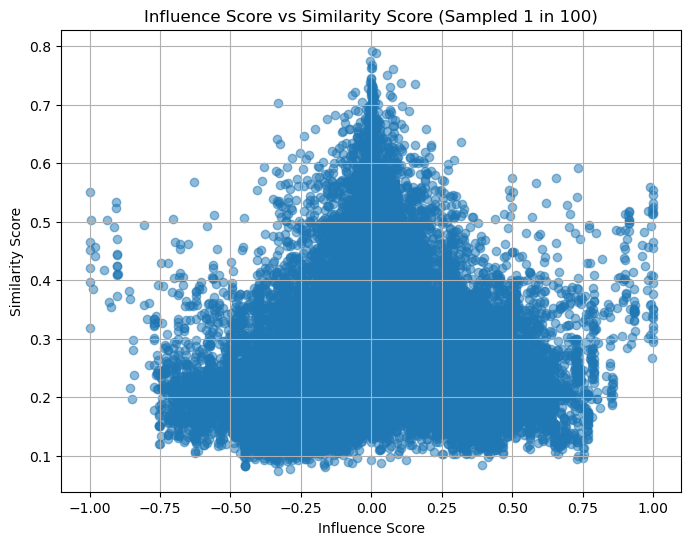

In [11]:
import matplotlib.pyplot as plt
plot_influence_vs_similarity(pairwise_influence_df_updated)